# Basic Model Interface (BMI) for streamflow prediction using Long Short-Term Memory (LSTM) networks
This Long Short-Term Memory (LSTM) network was developed for use in the [Next Generation National Water Model (Nextgen)](https://github.com/NOAA-OWP/ngen). Nextgen runs models with [Basic Model Interface (BMI)](https://bmi.readthedocs.io/en/latest/).

### These libraries should all be available in the environment.yml through the command
`conda activate bmi_lstm`

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from netCDF4 import Dataset
from lstm import bmi_lstm  # Load module bmi_lstm (bmi_lstm.py) from lstm package.
import pickle

### Set path to the project/repo folder for the LSTM model

When the LSTM Python model is used within NextGen, this folder will be in the "ngen" folder at: ngen/extern/lstm_py, and the LSTM Python package will be at: ngen/extern/lstm_py/lstm.  Note that paths to required datasets will be relative to this project folder.


In [2]:
import sys
## sys.path.append("../src/")

# Or just comment this out and cd to the lstm_py folder
import os, os.path
lstm_dir = os.path.expanduser('~/Dropbox/GitHub/ngen/extern/lstm_py')
os.chdir( lstm_dir )


### This sample dataset comes from NeuralHydrology: 
These are just samples. These models can run with any forcing data. This is just a sample that is used for examples within NeuralHydrology.
https://github.com/neuralhydrology/neuralhydrology/tree/master/test/test_data/camels_us/hourly
* 02064000 Falling River nr Naruna, VA
* 01547700 Marsh Creek at Blanchard, PA
* 03015500 Brokenstraw Creek at Youngsville, PA
* 01022500 Narraguagus River at Cherryfield, Maine

In [3]:
## sample_data = Dataset('../data/usgs-streamflow-nldas_hourly.nc', 'r')
sample_data = Dataset('./data/usgs-streamflow-nldas_hourly.nc', 'r')
sample_basins = {sample_data['basin'][x]:x for x in range(len(list(sample_data['basin'])))}

### Set a time constant
So that the time of the sample data aligns with the time of the NeuralHydrology evaluation. This will allow us to compare the implementation of the LSTM through BMI with that of the training. There will be some discrepancy between the NeuralHydrology evaluation, because that uses a 336 hour lookback period, and our BMI implementation does not reset the states. We will soon add the option to do a specific lookback period or not.

In [4]:
t2000 = 168721

# Test the model with the limited input

Initializing all forcings to 0...
  forcing_name = total_precipitation
  forcing_name = temperature
Forcing data info:
  n_precip = 26304
  n_temp   = 26304
  precip_data.dtype = float32
  temp_data.dtype   = float32
  precip:  min, max = 0.0 , 18.51529
  temp:    min, max = -27.690645 , 32.601532

Working, please wait...


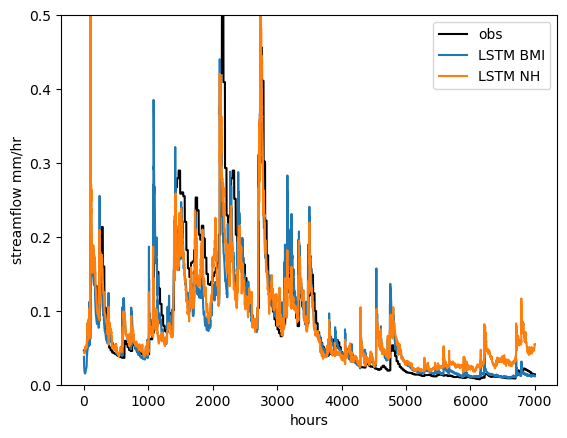

NSE: 0.72


In [5]:
# Load in the evaluation results from the NeuralHydrology training directory. This is just for plotting

# with open("../trained_neuralhydrology_models/hourly_slope_mean_precip_temp/test_results_01022500_E9.p", "rb") as fb:
with open("./trained_neuralhydrology_models/hourly_slope_mean_precip_temp/test_results_01022500_E9.p", "rb") as fb:
    eval_hourly_slope_mean_precip_temp_01022500_E9 = pickle.load(fb)    
nh_hourly_slope_mean_precip_temp_01022500 = \
    eval_hourly_slope_mean_precip_temp_01022500_E9['01022500']['1H']['xr']['QObs(mm/d)_sim'].data[:,-1]/24    

# Create an instance of the LSTM model with BMI
model_limited = bmi_lstm.bmi_LSTM()

# Initialize the model with a configuration file
# model_limited.initialize(bmi_cfg_file=Path('../bmi_config_files/01022500_hourly_slope_mean_precip_temp.yml'))
model_limited.initialize(bmi_cfg_file=Path('./bmi_config_files/01022500_hourly_slope_mean_precip_temp.yml'))

# The basin listed in the configuration has to be included in the sample basins for this example to run
# This is the location of the example basin in the sample data provided
ibasin = sample_basins[model_limited.cfg_bmi['basin_id']]
# Note that this model can run on any basin, but this example include observations from specific basins


# Run the model with sample data

# Get sample data time series for precip and temp
precip_data = sample_data['total_precipitation'][ibasin].data
temp_data   = sample_data['temperature'][ibasin].data
n_precip    = precip_data.size
print('Forcing data info:')
print('  n_precip =', n_precip)
print('  n_temp   =', temp_data.size)
print('  precip_data.dtype =', precip_data.dtype)
print('  temp_data.dtype   =', temp_data.dtype)
print('  precip:  min, max =', precip_data.min(), ',', precip_data.max() )
print('  temp:    min, max =', temp_data.min(), ',', temp_data.max() )
print()

# Store output values in a list, so we can plot it afterwards
# runoff_output_list_limited = []

# Store output values in an array, so we can plot it afterwards (faster)
runoff_output_limited = np.zeros( n_precip )

k = 0
VERBOSE = False
print('Working, please wait...')
for k in range( n_precip ):
    precip = precip_data[k]
    temp   = temp_data[k]
    if (VERBOSE):
        print('k, precip, temp =', k, ',', precip, ',', temp)

    # Set the model forcings to those in the sample data
    # model_limited.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    model_limited.set_value('atmosphere_water__liquid_equivalent_precipitation_rate', precip)
    model_limited.set_value('land_surface_air__temperature',temp)

    # Updating the model calculates the runoff from the inputs and the model state at this time step
    model_limited.update()

    # Add the output to a list so we can plot
    dest_array = np.zeros(1)
    #model_limited.get_value('land_surface_water__runoff_volume_flux',dest_array)
    model_limited.get_value('land_surface_water__runoff_depth', dest_array)
    runoff_limited = dest_array[0]
    # print('val =', runoff_limited)
    
    #------------------------------------------------
    # Make output unit consistant with CAMELS mm/hr
    #------------------------------------------------
    runoff_limited *= 1000   # (correct factor is 1000)
    # print('val =', runoff_limited)
    runoff_output_limited[ k ] = runoff_limited
    # runoff_output_list_limited.append(runoff_limited)

    
# Plot a portion of the output.
# start_plot=17000
# end_plot  =24000
start_plot=0
end_plot  =7000
plt.plot(sample_data['qobs_CAMELS_mm_per_hour'][ibasin][start_plot:end_plot], label='obs', c='k')
# plt.plot(runoff_output_list_limited[start_plot:end_plot],label='LSTM BMI')
plt.plot(runoff_output_limited[start_plot:end_plot],label='LSTM BMI')
plt.plot(nh_hourly_slope_mean_precip_temp_01022500[t2000+start_plot:t2000+end_plot],label='LSTM NH')
plt.ylim([0,0.5])
plt.ylabel('streamflow mm/hr')
plt.xlabel('hours')
plt.legend()
plt.show()
plt.close()

# Calculate a metric
obs = np.array(sample_data['qobs_CAMELS_mm_per_hour'][ibasin])
sim = runoff_output_limited
### sim = np.array(runoff_output_list_limited)
denominator = ((obs - obs.mean())**2).sum()
numerator = ((sim - obs)**2).sum()
value = 1 - numerator / denominator
print("NSE: {:.2f}".format(1 - numerator / denominator))

# Test the model with the complete set of inputs

Initializing all forcings to 0...
  forcing_name = total_precipitation
  forcing_name = longwave_radiation
  forcing_name = shortwave_radiation
  forcing_name = pressure
  forcing_name = specific_humidity
  forcing_name = temperature
  forcing_name = wind_u
  forcing_name = wind_v
Forcing data info:
  n_precip = 26304
  n_temp   = 26304
  precip_data.dtype = float32
  temp_data.dtype   = float32
  precip:  min, max = 0.0 , 18.51529
  temp:    min, max = -27.690645 , 32.601532

Working, please wait...


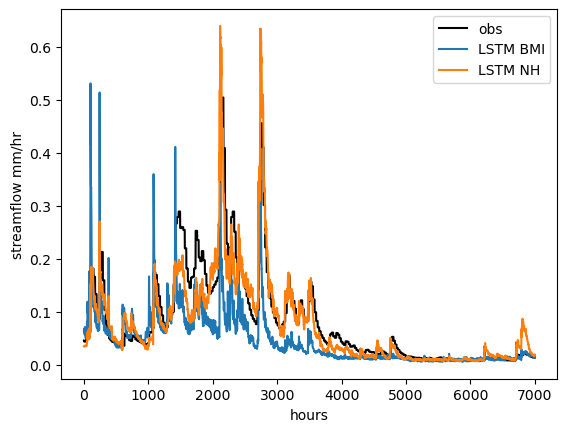

NSE: 0.40


In [6]:
# Load in the evaluation results from the NeuralHydrology training directory. This is just for plotting
## with open("../trained_neuralhydrology_models/hourly_all_attributes_and_forcings/test_results_01022500_E1.p", "rb") as fb:
with open("./trained_neuralhydrology_models/hourly_all_attributes_and_forcings/test_results_01022500_E1.p", "rb") as fb:
    eval_hourly_all_attributes_forcings_01022500_E1 = pickle.load(fb)
nh_hourly_all_attributes_forcings_01022500 = \
    eval_hourly_all_attributes_forcings_01022500_E1['01022500']['1H']['xr']['QObs(mm/d)_sim'].data[:,-1]/24

# Create an instance of the LSTM model with BMI
model_all = bmi_lstm.bmi_LSTM()

# Initialize the model with a configuration file
## model_all.initialize(bmi_cfg_file=Path('../bmi_config_files/01022500_hourly_all_attributes_forcings.yml'))
model_all.initialize(bmi_cfg_file=Path('./bmi_config_files/01022500_hourly_all_attributes_forcings.yml'))

# The basin listed in the configuration has to be included in the sample basins for this example to run
# This is the location of the example basin in the sample data provided
ibasin = sample_basins[model_all.cfg_bmi['basin_id']]
# Note that this model can run on any basin, but this example include observations from specific basins

# Get sample data time series for precip and temp
precip_data = sample_data['total_precipitation'][ibasin].data
temp_data   = sample_data['temperature'][ibasin].data
lwrad_data  = sample_data['longwave_radiation'][ibasin].data
swrad_data  = sample_data['shortwave_radiation'][ibasin].data
sh_data     = sample_data['specific_humidity'][ibasin].data
p0_data     = sample_data['pressure'][ibasin].data
uwind_data  = sample_data['wind_u'][ibasin].data
vwind_data  = sample_data['wind_v'][ibasin].data
n_precip    = precip_data.size

print('Partial forcing data info:')
print('  n_precip =', n_precip)
print('  n_temp   =', temp_data.size)
print('  precip_data.dtype =', precip_data.dtype)
print('  temp_data.dtype   =', temp_data.dtype)
print('  precip:  min, max =', precip_data.min(), ',', precip_data.max() )
print('  temp:    min, max =', temp_data.min(), ',', temp_data.max() )
print()

# Store output values in a list, so we can plot it afterwards
# runoff_output_list_limited = []

# Store output values in an array, so we can plot it afterwards (faster)
runoff_output_all = np.zeros( n_precip )

# Run the model with sample data

k = 0
VERBOSE = False
print('Working, please wait...')
for k in range( n_precip ): 
    if (VERBOSE):
        print('k, precip, temp =', k, ',', precip_data[k], ',', temp_data[k])

    # Set the model forcings to those in the sample data
    model_all.set_value('atmosphere_water__liquid_equivalent_precipitation_rate', precip_data[k] )
    model_all.set_value('land_surface_air__temperature',temp_data[k] )
    model_all.set_value('land_surface_radiation~incoming~longwave__energy_flux', lwrad_data[k] )
    model_all.set_value('land_surface_radiation~incoming~shortwave__energy_flux', swrad_data[k] )
    model_all.set_value('atmosphere_air_water~vapor__relative_saturation', sh_data[k] )
    model_all.set_value('land_surface_air__pressure', p0_data[k] )
    model_all.set_value('land_surface_wind__x_component_of_velocity', uwind_data[k] )
    model_all.set_value('land_surface_wind__y_component_of_velocity', vwind_data[k] )

    # Updating the model calculates the runoff from the inputs and the model state at this time step
    model_all.update()
    
    # Add the output to a list so we can plot
    model_all.get_value('land_surface_water__runoff_depth', dest_array)
    runoff_all = dest_array[0]
    runoff_all *= 1000   # (correct factor is 1000)
    # print('val =', runoff_all)
    #------------------------------------------------
    runoff_output_all[ k ] = runoff_all
    # runoff_output_list_all.append( runoff_all )
    
# Plot a portion of the output.
# start_plot = 0   # (use values already set previous cell)
# end_plot   = 7000
plt.plot(sample_data['qobs_CAMELS_mm_per_hour'][ibasin][start_plot:end_plot], label='obs', c='k')
plt.plot(runoff_output_all[start_plot:end_plot],label='LSTM BMI')
## plt.plot(runoff_output_list_all[start_plot:end_plot],label='LSTM BMI')
plt.plot(nh_hourly_all_attributes_forcings_01022500[t2000+start_plot:t2000+end_plot],label='LSTM NH')
#plt.ylim([0,0.5])
plt.ylabel('streamflow mm/hr')
plt.xlabel('hours')
plt.legend()
plt.show()
plt.close()

# Calculate a metric
obs = np.array(sample_data['qobs_CAMELS_mm_per_hour'][ibasin])
sim = runoff_output_all
## sim = np.array(runoff_output_list_all)
denominator = ((obs - obs.mean())**2).sum()
numerator = ((sim - obs)**2).sum()
value = 1 - numerator / denominator
print("NSE: {:.2f}".format(1 - numerator / denominator))



# Just show the forcings, for reference.

In [ ]:
for forcing in ['total_precipitation', 'temperature', 'longwave_radiation', 'shortwave_radiation',
                 'specific_humidity', 'pressure', 'wind_u', 'wind_v']:
    plt.plot(list(sample_data[forcing][ibasin].data)[start_plot:end_plot], '--', label=forcing)
    plt.title(forcing)
    plt.legend()
    plt.show()
    plt.close()
